Code used for the VISION presentation of M. Lecroël and P.L Barbarant.


Main reference : Ron Kimmel, *3d shape reconstruction from autostereograms and stereo*. [DOI](https://doi.org/10.1006/jvci.2001.0486)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import skimage
from skimage.util import random_noise
from tqdm import tqdm

# Part 1 : autostereograms generation

Generate simple 3D depth map from geometric shapes.

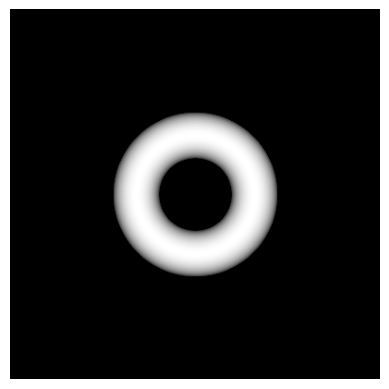

In [2]:
M = 400
N = 70
Z = np.zeros((M,M))
MAX_DEPTH = 10

def f(x,y, shape='sphere'):
    if shape == 'torus':
        return  25**2 - (8**2 - np.sqrt(x**2 + y**2))**2
    elif shape == 'sphere':
        return  100**2 - (x**2 + y**2)
    elif shape=='cone':
        return 50-np.sqrt(x**2 + y**2)

for j in range(-M//2, M//2):
    for i in range(-M//2, M//2):
        Z[i+M//2,j+M//2] = np.sqrt(max(f(i,j,shape='torus'), 0))

# Normalization
Z = (Z-Z.min())/(Z.max()-Z.min())*MAX_DEPTH

plt.imshow(Z, cmap='gray')
plt.axis('off')
plt.show()

Use the [shark](https://en.wikipedia.org/wiki/Autostereogram#/media/File:Stereogram_Tut_Shark_Depthmap.png) depth map.

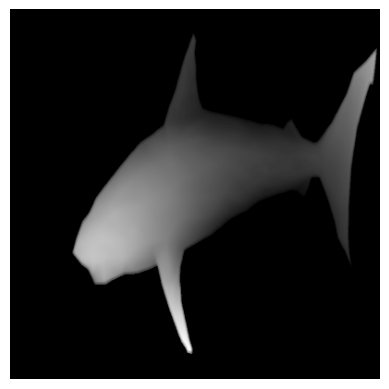

In [3]:
im = skimage.io.imread("shark.png", as_gray=True)

# Resize image
Z = skimage.transform.resize(im, (400, 400),anti_aliasing=True)


# Normalization
MAX_DEPTH = 10
Z = (Z-Z.min())/(Z.max()-Z.min())*MAX_DEPTH

plt.imshow(Z, cmap='gray')
plt.axis('off')
plt.show()

3D View :

/var/folders/1s/bxpqz56s6y12_hm461pg_g800000gn/T/ipykernel_7641/2611656525.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


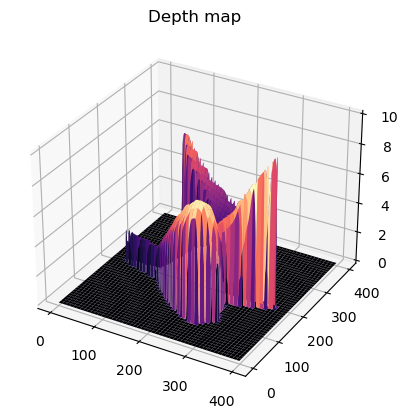

In [4]:
# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:Z.shape[0], 0:Z.shape[1]]

# create the figure
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, Z, cmap='magma', linewidth=0)
ax.set_title('Depth map')

# show it
plt.show()

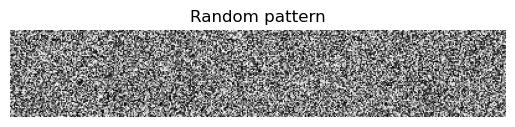

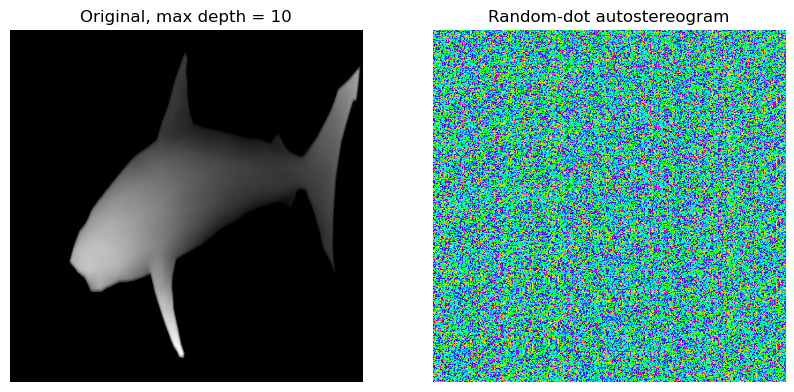

In [5]:
R = np.random.randint(0, N , size=(N,M))

I = np.zeros((M,M))
for j in range(M):
    for i in range(M):
        if i < N:
            I[i,j] = R[i,j]
        else:
            I[i,j] = I[i-N + int(Z[i,j]), j]

plt.imshow(R, cmap='gray')
plt.title('Random pattern')
plt.axis('off')
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,20))
ax1.imshow(Z, cmap='gray')
ax2.imshow(I, cmap='hsv')           # Change the colormap to vary the look of the autostereogram
ax1.axis('off')
ax2.axis('off')
ax1.set_title(f"Original, max depth = {MAX_DEPTH}")
ax2.set_title('Random-dot autostereogram')
plt.show()

# Part 2 : 3D scene reconstruction

With first correlation :

In [6]:
output0 = np.zeros((M, M))
for j in tqdm(range(M)):
    for i in range(N, M):
        k_list = [N]
        for k in range(1,N):
            if I[i,j] == I[i-k, j]:
                k_list.append(k)
        output0[i,j] = N-min(k_list)


100%|██████████| 400/400 [00:01<00:00, 201.37it/s]


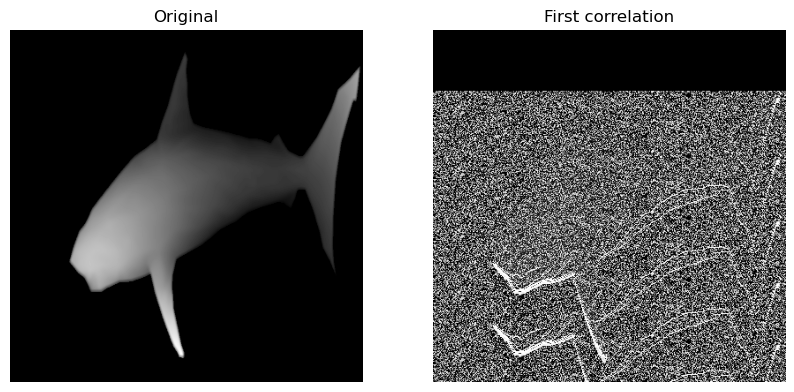

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,20))
ax1.imshow(Z, cmap='gray')
ax2.imshow(output0, cmap='gray')
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('First correlation')
plt.show()

With smoothness assumption :

In [8]:
output = np.zeros((M, M, N-1))
for j in tqdm(range(M)):
    for i in range(N, M):
        for k in range(1,N):
            if I[i,j] == I[i-k, j]:
                output[i,j,k-1] = k
            else:
                output[i,j,k-1] = N
        output[i,j,:] = N-np.sort(output[i,j,:])

100%|██████████| 400/400 [00:03<00:00, 119.07it/s]


In [9]:
def normal(triangles):
    # The cross product of two sides is a normal vector
    return np.cross(triangles[:,1] - triangles[:,0], 
                    triangles[:,2] - triangles[:,0], axis=1)

def area(triangles):
    # The norm of the cross product of two sides is twice the area
    return np.linalg.norm(normal(triangles), axis=1) / 2

def six_triangles_area(i, j, k, output, Z):
    triangles = np.array([[[i, j, output[i,j,k]],
                           [i-1, j, Z[i-1,j]],
                           [i, j+1, Z[i,j+1]]],
                           
                           [[i, j, output[i,j,k]],
                           [i-1, j, Z[i-1,j]],
                           [i-1, j-1, Z[i,j+1]]],

                           [[i, j, output[i,j,k]],
                           [i, j-1, Z[i,j-1]],
                           [i-1, j-1, Z[i,j+1]]],
                           
                           [[i, j, output[i,j,k]],
                           [i, j-1, Z[i,j-1]],
                           [i+1, j, Z[i+1,j]]],
                           
                           [[i, j, output[i,j,k]],
                           [i+1, j+1, Z[i+1,j+1]],
                           [i+1, j, Z[i+1,j]]],

                           [[i, j, output[i,j,k]],
                           [i+1, j+1, Z[i+1,j+1]],
                           [i, j+1, Z[i,j+1]]]])

    return area(triangles).sum()

Minimal surface refinement (MSR) :

In [10]:
Z_reconstructed = np.copy(output[:,:,0])

MAX_ITER = 10
for iter in tqdm(range(MAX_ITER)):
    for i in range(1, M-1):
        for j in range(1, M-1):
            m = 10**9
            for k in range(0,output[i,j,:].argmin()+1):
                temp = output[i,j,k]
                if temp >=0 and temp <= N:
                    sum_area = six_triangles_area(i,j,k , output=output, Z=Z_reconstructed)
                    if sum_area < m :
                        Z_reconstructed[i,j] = temp
                        m = sum_area

100%|██████████| 10/10 [01:26<00:00,  8.62s/it]


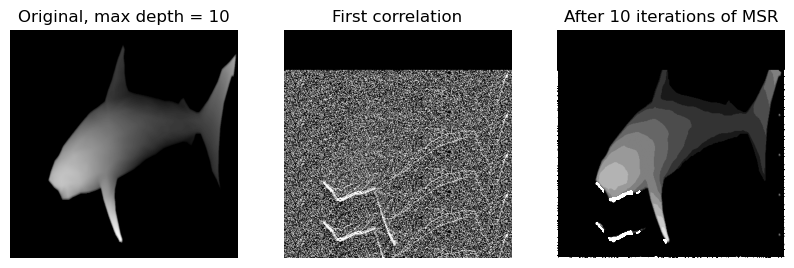

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,10))
ax1.imshow(Z, cmap='gray')
ax2.imshow(output[:,:,0], cmap='gray')
ax3.imshow(Z_reconstructed, cmap='gray', vmax=MAX_DEPTH)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax1.set_title(f"Original, max depth = {MAX_DEPTH}")
ax2.set_title('First correlation')
ax3.set_title(f"After {MAX_ITER} iterations of MSR")
plt.show()